In [62]:
import json
import requests
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt

In [73]:
def df_sql(table_name, db_name):
    """Extract table <table_name> from database <db_name>.db"""
    with sqlite3.connect(f"data/boardlib/{db_name}.db") as conn:
        q = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(q,conn,index_col='id')
    return df

# Configuration
API_BASE_URL = "http://localhost:8000"  # Adjust if your API is running elsewhere
WALL_ID = "wall-6b808d81cfc0"  # TB2 Mirror

def convert_dataframe_to_holds(df: pd.DataFrame, 
                                 default_pull_x: float = 0.0,
                                 default_pull_y: float = -1.0,
                                 default_useability: float = 0.5) -> list[dict]:
    """
    Convert pandas DataFrame to list of hold dictionaries.
    
    Args:
        df: DataFrame with 'hole_id', 'x_ft', 'y_ft' columns
        default_pull_x: Default pull direction x-component
        default_pull_y: Default pull direction y-component  
        default_useability: Default difficulty rating (0-1)
        default_is_foot: Whether hold is a foothold (0 or 1)
    
    Returns:
        List of hold dictionaries matching the API schema
    """
    holds = []
    
    for _, row in df.iterrows():
        hold = {
            "hold_index": int(row['hole_id']),
            "x": float(row['x_ft']),
            "y": float(row['y_ft']),
            "pull_x": default_pull_x,
            "pull_y": default_pull_y,
            "useability": default_useability,
            "is_foot": int(row['is_foot'])
        }
        holds.append(hold)
    
    return holds


def upload_holds(wall_id: str, holds: list[dict], api_base_url: str = API_BASE_URL) -> dict:
    """
    Upload holds to the API.
    
    Args:
        wall_id: The wall ID to upload holds to
        holds: List of hold dictionaries
        api_base_url: Base URL of the API
    
    Returns:
        Response JSON from the API
    """
    endpoint = f"{api_base_url}/api/v1/walls/{wall_id}/holds"
    
    # Prepare form data with JSON-encoded holds
    form_data = {
        "holds": json.dumps(holds)
    }
    
    print(f"Uploading {len(holds)} holds to wall {wall_id}...")
    print(f"Endpoint: {endpoint}")
    
    response = requests.put(endpoint, data=form_data)
    
    if response.status_code == 201:
        print(f"✓ Successfully uploaded {len(holds)} holds!")
        return response.json()
    else:
        print(f"✗ Upload failed with status {response.status_code}")
        print(f"Error: {response.text}")
        response.raise_for_status()

In [51]:
df_holes = df_sql("holes","tension").astype({'product_id':int, 'name':str,'x':int,'y':int,'mirrored_hole_id':int,'mirror_group':int})
df_holes.head()

,product_id,name,x,y,mirrored_hole_id,mirror_group
id,,,,,,
1,4,"A,18",8,152,11,0
2,4,"B,18",16,152,10,0
3,4,"C,18",24,152,9,0
4,4,"D,18",32,152,8,0
5,4,"E,18",40,152,7,0


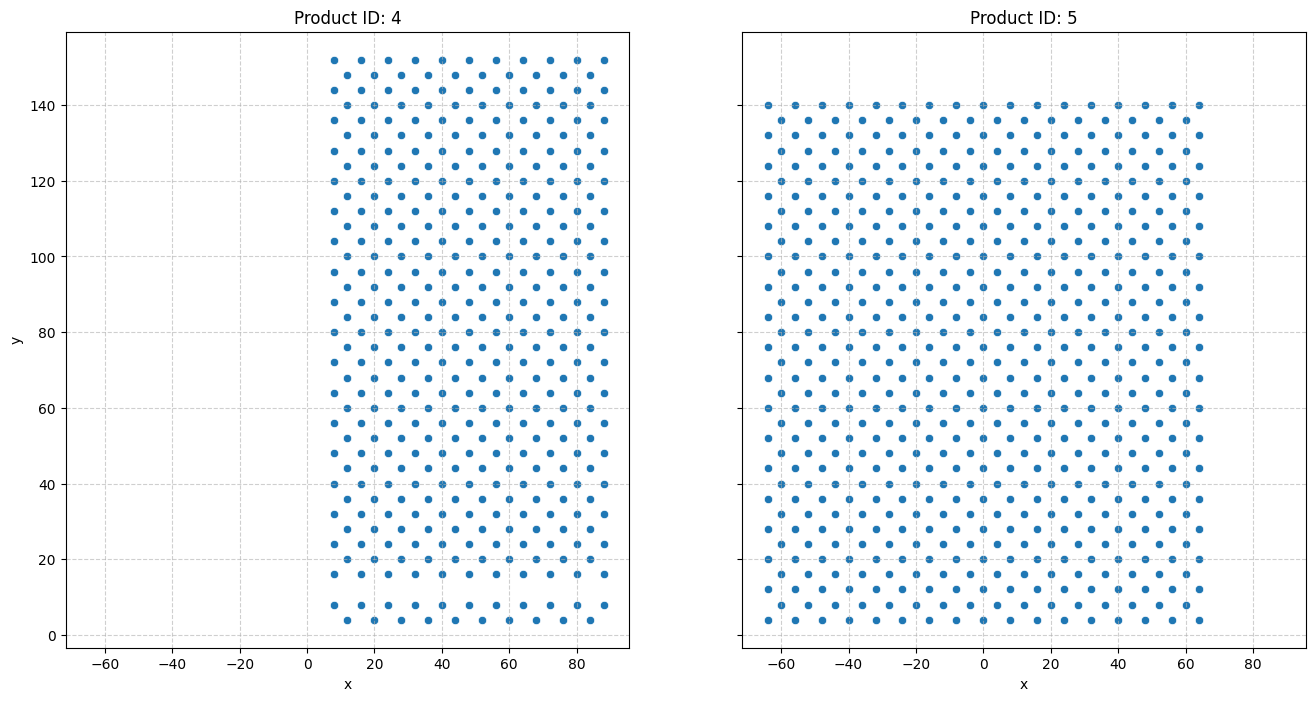

In [25]:
fig, axes = plt.subplots(1,2,figsize=(16,8), sharex=True, sharey=True)

for i,product_id in enumerate([4,5]):
    filtered = df_holes[df_holes["product_id"]==product_id]
    sns.scatterplot(filtered, x='x',y='y',ax=axes[i])
    axes[i].set_title(f"Product ID: {product_id}")
    axes[i].grid(True,alpha=.6, linestyle='--')

plt.show()

### Product 4 is the TB1, Product 5 is the TB2. We need to convert both of these hold-sets to real, physical holds. First step would be aligning them with their real, physical location on the board. Second step would be finding some way to manually add pull_dir+useability features.

I learned from the TB2 installation guide that these hole location measurements are in inches. Additionally, the TB2 DOESN'T HAVE A KICKBOARD! That's crazy, and a bit of a Mandela effect for me. I could swear it had one. But nope.

**The guide also comes with crystal clear hold orientations, and difficulty levels. This is exactly the data I'm looking for! Fuck yeah, Tension!** 

In [34]:
df_placements = df_sql("placements","tension").astype({'layout_id':int,'hole_id':int,'set_id':int,'default_placement_role_id':int})
tb2_layouts = [10,11]
df_placements = df_placements[df_placements['layout_id'].isin(tb2_layouts)].merge(
    df_holes,
    left_on='hole_id',
    right_on='id',
    how='outer'
)
df_placements.head()

,layout_id,hole_id,set_id,default_placement_role_id,product_id,name,x,y,mirrored_hole_id,mirror_group
0,10,672,12,8,5,"0,20",0,20,672,0
1,11,390,12,8,5,"-64,4",-64,4,950,0
2,10,675,12,5,5,"0,44",0,44,675,0
3,11,392,12,8,5,"-64,20",-64,20,952,0
4,10,676,12,6,5,"0,52",0,52,676,0


In [66]:
df_placements['x_ft'] = (df_placements['x']+72)/12
df_placements['y_ft'] = (df_placements['y'])/12
df_placements['is_foot'] = (df_placements['default_placement_role_id']%4==0).astype(int)
tb2_mirror = df_placements.loc[df_placements['layout_id']==10,['hole_id','x_ft','y_ft','is_foot']]
tb2_spray = df_placements.loc[df_placements['layout_id']==11,['hole_id','x_ft','y_ft','is_foot']]
tb2_spray.head()

,hole_id,x_ft,y_ft,is_foot
1,390,0.666667,0.333333,1
3,392,0.666667,1.666667,1
5,394,0.666667,3.000000,0
7,396,0.666667,4.333333,0
9,399,0.666667,6.333333,0


In [71]:
min(tb2_mirror['y_ft'])

0.3333333333333333

In [80]:
spray_holds = convert_dataframe_to_holds(tb2_spray)
upload_holds('wall-443c15cd12e0',spray_holds)

Uploading 498 holds to wall wall-443c15cd12e0...
Endpoint: http://localhost:8000/api/v1/walls/wall-443c15cd12e0/holds
✓ Successfully uploaded 498 holds!


{'id': 'wall-443c15cd12e0'}

In [81]:
spray_holds[0]

{'hold_index': 390,
 'x': 0.6666666666666666,
 'y': 0.3333333333333333,
 'pull_x': 0.0,
 'pull_y': -1.0,
 'useability': 0.5,
 'is_foot': 1}